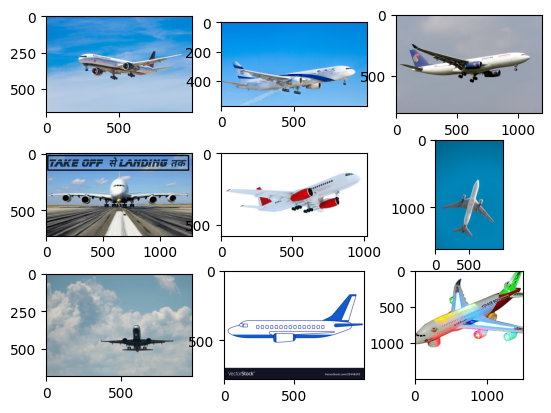

In [3]:
#Code to visualize the images


# plot dog photos from the dogs vs cats dataset
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = 'Dataset/Airplanes/Train/'
# plot first few images
for i in range(9):
 # define subplot
 pyplot.subplot(330 + 1 + i)
 # define filename
 filename = folder + '0000000' + str(i) + '.jpg'
 # load image pixels
 image = imread(filename)
 # plot raw pixel data
 pyplot.imshow(image)
# show the figure
pyplot.show()


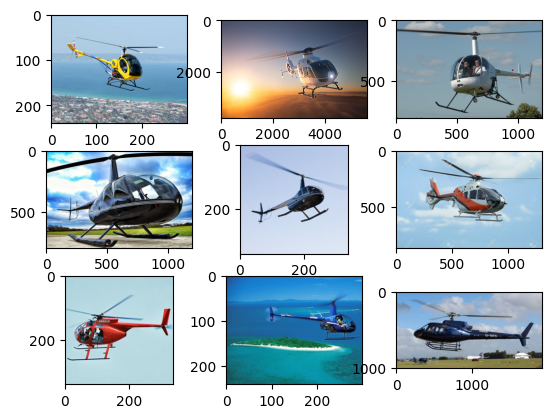

In [4]:
#Code to visualize the images


# plot dog photos from the dogs vs cats dataset
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = 'Dataset/Helicopters/Train/'
# plot first few images
for i in range(9):
 # define subplot
 pyplot.subplot(330 + 1 + i)
 # define filename
 filename = folder + '0000000' + str(i) + '.jpg'
 # load image pixels
 image = imread(filename)
 # plot raw pixel data
 pyplot.imshow(image)
# show the figure
pyplot.show()


VGG1

In [11]:
# baseline model for the dogs vs cats dataset
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	pyplot.savefig('plot_block1.png')
	pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('Dataset/Train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('Dataset/Test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
	# evaluate model
	_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()

Found 159 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


C:\Users\Dell\AppData\Local\Temp\ipykernel_15212\1548179593.py:54: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
C:\Users\Dell\AppData\Local\Temp\ipykernel_15212\1548179593.py:57: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)


> 50.000


VGG 2

In [12]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	pyplot.savefig('plot_block2.png')
	pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('Dataset/Train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('Dataset/Test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
	# evaluate model
	_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()

Found 159 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


C:\Users\Dell\AppData\Local\Temp\ipykernel_15212\730036687.py:43: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
C:\Users\Dell\AppData\Local\Temp\ipykernel_15212\730036687.py:46: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)


> 70.000


VGG3

In [13]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	pyplot.savefig('plot_block3.png')
	pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('Dataset/Train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('Dataset/Test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
	# evaluate model
	_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()

Found 159 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


C:\Users\Dell\AppData\Local\Temp\ipykernel_15212\4133096134.py:46: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
C:\Users\Dell\AppData\Local\Temp\ipykernel_15212\4133096134.py:49: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)


> 60.000


VGG 3 with data augmentation

In [14]:
# define cnn model
def define_model():
 model = Sequential()
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
 model.add(MaxPooling2D((2, 2)))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Flatten())
 model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
 model.add(Dense(1, activation='sigmoid'))
 # compile model
 opt = SGD(lr=0.001, momentum=0.9)
 model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
 return model
 
# plot diagnostic learning curves
def summarize_diagnostics(history):
 # plot loss
 pyplot.subplot(211)
 pyplot.title('Cross Entropy Loss')
 pyplot.plot(history.history['loss'], color='blue', label='train')
 pyplot.plot(history.history['val_loss'], color='orange', label='test')
 # plot accuracy
 pyplot.subplot(212)
 pyplot.title('Classification Accuracy')
 pyplot.plot(history.history['accuracy'], color='blue', label='train')
 pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
 # save plot to file
 filename = sys.argv[0].split('/')[-1]
 pyplot.savefig('plot4.png')
 pyplot.close()
 
# run the test harness for evaluating a model
def run_test_harness():
 # define model
 model = define_model()
 # create data generators
 train_datagen = ImageDataGenerator(rescale=1.0/255.0,
 width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
 test_datagen = ImageDataGenerator(rescale=1.0/255.0)
 # prepare iterators
 train_it = train_datagen.flow_from_directory('Dataset/Train/',
 class_mode='binary', batch_size=64, target_size=(200, 200))
 test_it = test_datagen.flow_from_directory('Dataset/Test/',
 class_mode='binary', batch_size=64, target_size=(200, 200))
 # fit model
 history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
 validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=0)
 # evaluate model
 _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
 print('> %.3f' % (acc * 100.0))
 # learning curves
 summarize_diagnostics(history)
 
# entry point, run the test harness
run_test_harness()

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


C:\Users\Dell\AppData\Local\Temp\ipykernel_15212\295775124.py:49: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
C:\Users\Dell\AppData\Local\Temp\ipykernel_15212\295775124.py:52: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)


> 82.500
